# Python for Intelligent Supernova-COsmology Light-Curve Analysis: __PISCOLA__

by Tomás Müller (University of Southampton)

In [1]:
import piscola as pisco
import numpy as np

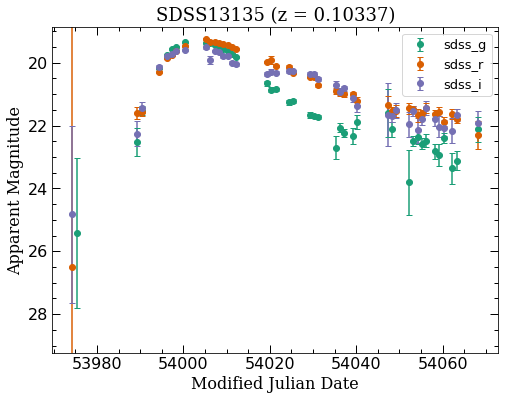

/home/muller/anaconda3/envs/pisco/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


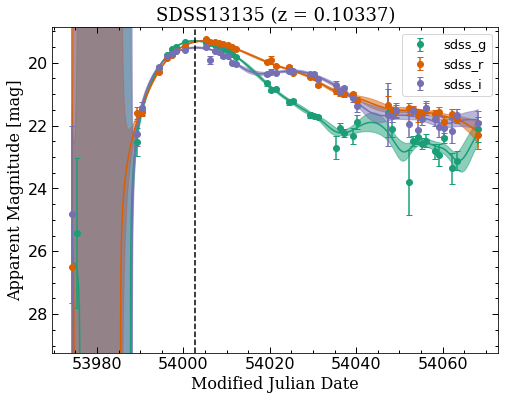

Initial B-band peak estimation: 54002.61


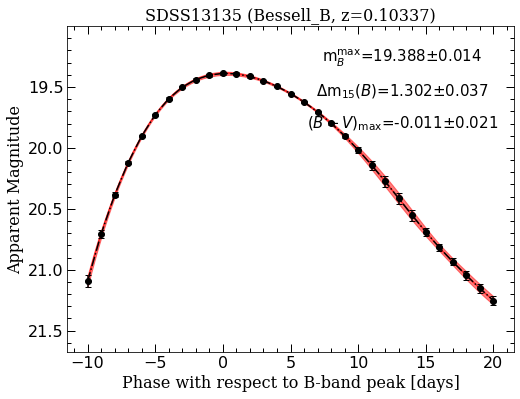

54002.61


In [2]:
sn = pisco.sn_file('SDSS13135', directory='data_pantheon/')
    
sn.delete_bands(['sdss_u', 'sdss_z'])    
sn.normalize_data()
sn.plot_data()
sn.fit_lcs()
sn.plot_fits()

print('Initial B-band peak estimation:', sn.tmax)

sn.mangle_sed(-10, 20)
sn.calculate_lc_params()
sn.display_results('Bessell_B')
print(sn.tmax)

/home/muller/anaconda3/envs/pisco/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


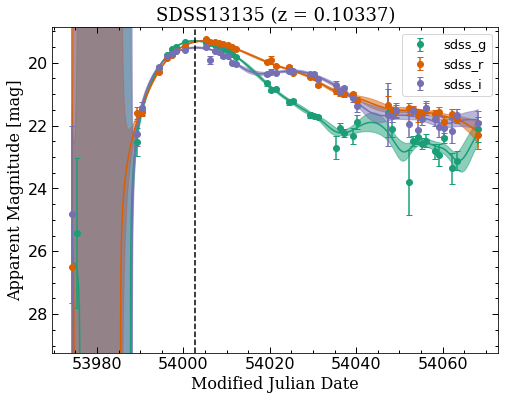

In [3]:
sn.plot_fits()
dt = (sn.data[sn.pivot_band]['mjd'] - sn.tmax)/(1+sn.z)  # in restframe
if not np.any(np.abs(dt)<=2.5):
    print('no hay datos around peak')

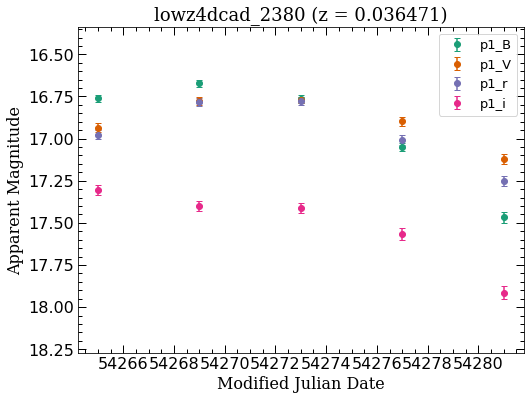

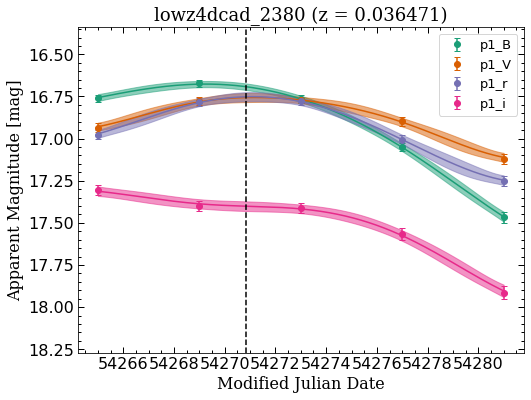

Initial B-band peak estimation: 54270.85178243277


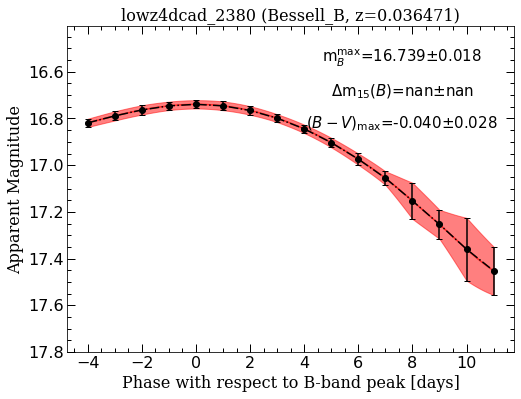

54272.06178243277


In [2]:
sn = pisco.sn_file('lowz4dcad_2380', directory='data_simulations/')
    
sn.set_sed_template('jla')
sn.normalize_data()
sn.plot_data()
sn.fit_lcs()
sn.plot_fits()

print('Initial B-band peak estimation:', sn.tmax)

sn.mangle_sed(-10, 20, correct_extinction=False)
sn.calculate_lc_params()
sn.display_results('Bessell_B')
print(sn.tmax)

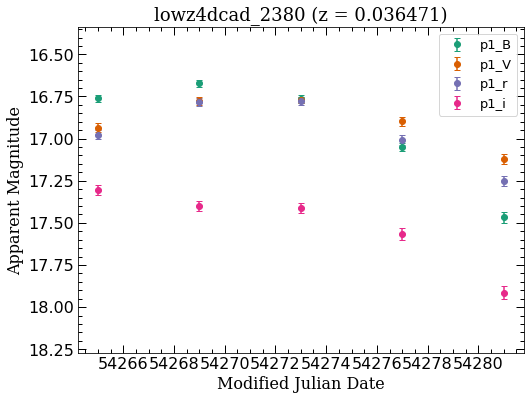

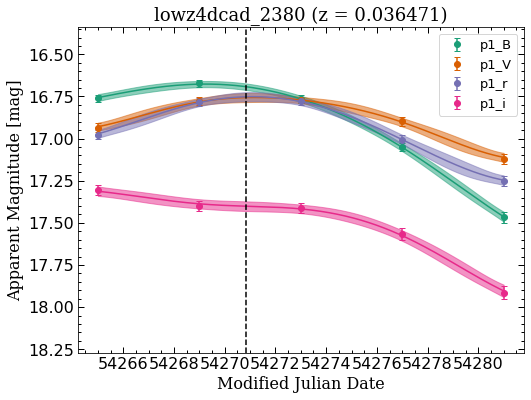

Initial B-band peak estimation: 54270.85178243277


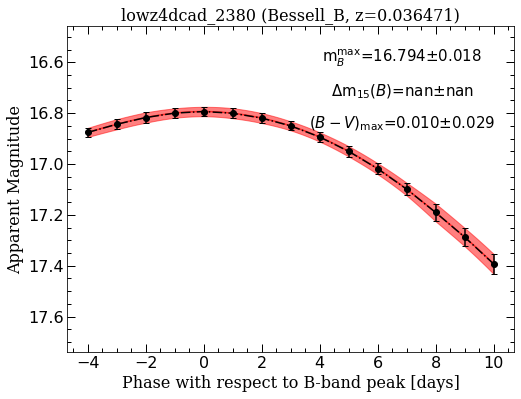

54272.05178243277


In [13]:
sn = pisco.sn_file('lowz4dcad_2380', directory='data_simulations/')
    
sn.normalize_data()
sn.plot_data()
sn.fit_lcs()
sn.plot_fits()

print('Initial B-band peak estimation:', sn.tmax)

sn.mangle_sed(-10, 20, correct_extinction=False)
sn.calculate_lc_params()
sn.display_results('Bessell_B')
print(sn.tmax)

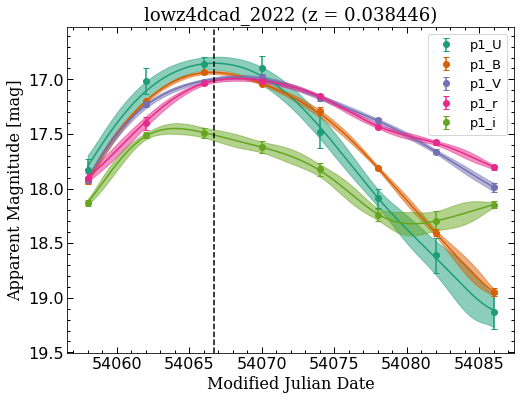

p1_U 16.85214674470108
p1_B 16.93587502819257
p1_V 16.978770977357293
p1_r 16.99286897278801
p1_i 17.450143496599086


In [10]:
sn = pisco.sn_file('lowz4dcad_2022', directory='data_simulations/')

sn.normalize_data()
sn.fit_lcs()
sn.plot_fits()

for band in sn.bands:
    mmax = sn.lc_fits[band]['mmax']
    print(band, mmax)

___
___
___

# JLA

In [ ]:
%load_ext line_profiler
from multiprocessing import Pool
import piscola as pisco
import pandas as pd
import numpy as np
import glob
import os

SAMPLE = 'jla'
output_extension = ''
obj_path = f'obj_jla{output_extension}/'

try:
    os.mkdir(obj_path)
except:
    pass

def run_piscola(sn_name, verbose=True):
    try:
        sn = pisco.sn_file(sn_name, directory=f'data_{SAMPLE}/')
        if verbose:
            print(f'processing {sn_name}...')
        
        sn.set_sed_epoch()
        sn.normalize_data()
        
        # JLA bands
        sn.delete_bands(['sdss_u'])
        if sn.name.startswith('sn'):
            # for Low-z with SDSS observations to avoid too many bands
            sn.delete_bands(['sdss_g', 'sdss_r', 'sdss_i', 'sdss_z'])
        if sn.z > 0.45:
            # g-band is not necessary to cover B-band anymore
            sn.delete_bands(['Megacam_g'])
        
        sn.fit_lcs()
        sn.mask_data(min_phase=-40, max_phase=60)
        sn.fit_lcs()
        
        # continue if there is at least one data points on each side of the peak within -5 and +5 days
        data_peak = [mjd for mjd in sn.data[sn.pivot_band]['mjd'] if -5 <= (mjd - sn.tmax) <= 5]
        assert len(data_peak) >= 2, f'{sn_name} needs better peak coverage (more than 2 points)!'

        phases = np.r_[np.arange(-15, -5), np.arange(-5, 5, 0.5), np.arange(5, 31)]
        sn.set_interp_data(restframe_phases=phases)

        sn.correct_light_curve(scaling=1.0)
        sn.calc_lc_parameters()
        sn.save(sn_name, path=obj_path)
        if verbose:
            print(f'{sn_name} successful!')
        return sn.name
    except Exception as e: 
        if verbose:
            print(f'{sn_name} failed:', e)
        
def save_pisco_results(sn_list, obj_path, output_file):
    
    params = pd.DataFrame({'sn':[], 'z':[], 'tmax':[], 'mb':[], 'dmb':[],'dm15':[], 'dm15err':[], 'color':[], 'dcolor':[]})

    for sn_name in sn_list: 

        if sn_name is not None:
            sn = pisco.load_sn(sn_name, path=obj_path)
            tmax = sn.tmax
            mb = sn.lc_parameters['mb']
            dmb = sn.lc_parameters['dmb']
            dm15 = sn.lc_parameters['dm15']
            dm15err = sn.lc_parameters['dm15err']
            color = sn.lc_parameters['color']
            dcolor = sn.lc_parameters['dcolor']

            columns = ['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']
            values = [sn.name, sn.z, tmax, mb, dmb, dm15, dm15err, color, dcolor]

            row = pd.DataFrame(data=[values], columns=columns)
            params = params[['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']].append(row)

    params.to_csv(output_file, index=False)

In [ ]:
processes = 8
data_path = f'data_{SAMPLE}/*'

lowz = [file.split('/')[1][:-4] for file in glob.glob(data_path) if 'sn' in file]
sdss = [file.split('/')[1][:-4] for file in glob.glob(data_path) if 'SDSS' in file]
snls = [file.split('/')[1][:-4] for file in glob.glob(data_path) if file.split('/')[1].startswith('0')]
hst = [file.split('/')[1][:-4] for file in glob.glob(data_path) if (file.split('/')[1][:-4] not in lowz) 
       & (file.split('/')[1][:-4] not in sdss) & (file.split('/')[1][:-4] not in snls)]

samples_dict = {f'lowz_{SAMPLE}':lowz, f'sdss_{SAMPLE}':sdss, f'snls_{SAMPLE}':snls, f'hst_{SAMPLE}':hst}

___
___
___
# Pantheon

In [1]:
%load_ext line_profiler
from multiprocessing import Pool
import piscola as pisco
import pandas as pd
import numpy as np
import glob
import os

class NoDataAroundPeak(Exception):
    """Raised and exception if the SN does not have data close to peak."""
    pass

SAMPLE = 'pantheon'
obj_path = f'obj_{SAMPLE}/'

try:
    os.mkdir(obj_path)
except:
    pass

def run_piscola(sn_name):
    try:
        sn = pisco.sn_file(sn_name, directory=f'data_{SAMPLE}/')
        
        sn.delete_bands(['sdss_u', 'sdss_z'])
        if 'csp_g' in sn.bands and 'csp_B' in sn.bands:
            sn.delete_bands(['csp_g'])
        if sn.z > 0.43:
            sn.delete_bands(['ps1_g'])
        if sn.z > 0.48:
            sn.delete_bands(['Megacam_g'])
            
        sn.normalize_data()
        sn.fit_lcs()

        sn.mangle_sed(-10, 20)
        sn.calculate_lc_params()
        dt = (sn.data[sn.pivot_band]['mjd'] - sn.tmax)/(1+sn.z)  # in restframe
        if not np.any(np.abs(dt)<=2.5):
            raise NoDataAroundPeak
            
        sn.save(sn_name, path=obj_path)
        print(f'{sn_name} successful!')
        return sn.name
    except NoDataAroundPeak:
        print(f'{sn_name} does not have data from the pivot band around peak')
    except Exception as e: 
        print(f'{sn_name} failed:', e)
        
def save_pisco_results(sn_list, obj_path, output_file):
    params = pd.DataFrame({'sn':[], 'z':[], 'tmax':[], 'mb':[], 'dmb':[],'dm15':[], 'dm15err':[], 'color':[], 'dcolor':[]})

    for sn_name in sn_list: 
        try:
            sn = pisco.load_sn(sn_name, path=obj_path)
            tmax = sn.tmax
            mb = sn.lc_parameters['mb']
            dmb = sn.lc_parameters['dmb']
            dm15 = sn.lc_parameters['dm15']
            dm15err = sn.lc_parameters['dm15err']
            color = sn.lc_parameters['color']
            dcolor = sn.lc_parameters['dcolor']

            columns = ['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']
            values = [sn.name, sn.z, tmax, mb, dmb, dm15, dm15err, color, dcolor]

            row = pd.DataFrame(data=[values], columns=columns)
            params = params[['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']].append(row)
        except:
            pass

    params.to_csv(output_file, index=False)

In [2]:
processes = 24
data_path = f'data_{SAMPLE}/*'

lowz = [file.split('/')[1][:-4] for file in glob.glob(data_path) if 'sn' in file]
sdss = [file.split('/')[1][:-4] for file in glob.glob(data_path) if 'SDSS' in file]
snls = [file.split('/')[1][:-4] for file in glob.glob(data_path) if file.split('/')[1].startswith('0')]
ps1 = [file.split('/')[1][:-4] for file in glob.glob(data_path) if file.split('/')[1].startswith('psc')]
hst = [file.split('/')[1][:-4] for file in glob.glob(data_path) if (file.split('/')[1][:-4] not in lowz) 
       & (file.split('/')[1][:-4] not in sdss) & (file.split('/')[1][:-4] not in snls) & (file.split('/')[1][:-4] not in ps1)]

subsamples_dict = {f'{SAMPLE}_lowz':lowz, f'{SAMPLE}_sdss':sdss, f'{SAMPLE}_snls':snls, f'{SAMPLE}_ps1':ps1, f'{SAMPLE}_hst':hst}
for subsam, sublist in subsamples_dict.items():
    print(f'{subsam}: {len(sublist)} SNe')

pantheon_lowz: 172 SNe
pantheon_sdss: 335 SNe
pantheon_snls: 236 SNe
pantheon_ps1: 279 SNe
pantheon_hst: 26 SNe


In [3]:
subsample = f'{SAMPLE}_lowz'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

sn1998dk failed: Unable to obtain B-band peak for sn1998dk!
sn1997Y failed: Unable to obtain B-band peak for sn1997Y!
sn1993ac failed: Unable to obtain B-band peak for sn1993ac!
sn2002kf failed: Unable to obtain B-band peak for sn2002kf!
sn2001gb failed: Unable to obtain B-band peak for sn2001gb!
sn2002bz failed: Unable to obtain B-band peak for sn2002bz!
sn2001az failed: Unable to obtain B-band peak for sn2001az!
sn2000B failed: Unable to obtain B-band peak for sn2000B!
sn1998dx failed: Unable to obtain B-band peak for sn1998dx!
sn1996bv failed: Unable to obtain B-band peak for sn1996bv!
sn1999ef failed: Unable to obtain B-band peak for sn1999ef!
sn1994M failed: Unable to obtain B-band peak for sn1994M!
sn2001ic failed: Unable to obtain B-band peak for sn2001ic!
sn2002ck failed: Unable to obtain B-band peak for sn2002ck!
sn2001en failed: Unable to obtain B-band peak for sn2001en!
sn1993ae failed: Unable to obtain B-band peak for sn1993ae!
sn2001da failed: Unable to obtain B-band peak 

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sn2003cq failed: 'float' object is not subscriptable
sn2005M failed: fit aborted by user.
sn2005be failed: Unable to obtain B-band peak for sn2005be!
sn2000cf successful!
sn2005hf failed: Unable to obtain B-band peak for sn2005hf!
sn1997dg successful!
sn2002dp successful!
sn2002eu failed: Unable to obtain B-band peak for sn2002eu!
sn1994S successful!
sn1997E successful!
sn2003it successful!
sn1995ak failed: Unable to obtain B-band peak for sn1995ak!
sn1999cc successful!
sn2003U successful!
sn2000cn does not have data from the pivot band around peak
sn2006N failed: Unable to obtain B-band peak for sn2006N!
sn2002ha successful!
sn2005hj successful!
sn2006ah failed: Unable to obtain B-band peak for sn2006ah!
sn2000fa does not have data from the pivot band around peak
sn2001G failed: Unable to obtain B-band peak for sn2001G!
sn2006ak failed: Unable to obtain B-band peak for sn2006ak!
sn2006al failed: Unable to obtain B-band peak for sn2006al!
sn2004as successful!
sn2002cr successful!
sn200

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sn2010Y successful!
sn2007cq successful!
sn2004eo successful!
sn2010A successful!
snPTF10bjs failed: 'float' object is not subscriptable
sn2009ds successful!
sn2007ca successful!
sn2007nq successful!
sn2008050 successful!
sn2009kq does not have data from the pivot band around peak
sn2009ad successful!
sn2008gp successful!
sn2008bf successful!
sn2008bq successful!
sn2008hv successful!
sn2007bc successful!
sn2005iq successful!
sn2005kc successful!


Process ForkPoolWorker-3:
Process ForkPoolWorker-18:
Process ForkPoolWorker-15:
Process ForkPoolWorker-24:
Process ForkPoolWorker-19:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-20:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-11:
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Process ForkPoolWorker-12:
Process ForkPoolWorker-16:
  File "/home/muller/anaconda3/envs/pisco/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-8:
Traceback (most recent call last):
  File "/home/muller/anaconda3/envs/pisco/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most re

CPU times: user 508 ms, sys: 236 ms, total: 744 ms
Wall time: 1h 35min


In [4]:
subsample = f'{SAMPLE}_sdss'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

SDSS12971 failed: Unable to obtain B-band peak for SDSS12971!
SDSS10028 successful!
SDSS13025 successful!
SDSS15301 successful!
SDSS14108 successful!
SDSS15132 successful!
SDSS15383 successful!
SDSS13578 successful!
SDSS13354 successful!
SDSS13136 successful!
SDSS12898 successful!
SDSS13757 successful!
SDSS12927 failed: Unable to obtain B-band peak for SDSS12927!
SDSS12928 failed: Unable to obtain B-band peak for SDSS12928!
SDSS1112 successful!
SDSS13894 successful!
SDSS13689 successful!
SDSS14421 successful!
SDSS13038 successful!
SDSS12972 does not have data from the pivot band around peak
SDSS1241 successful!
SDSS1032 successful!
SDSS12781 successful!
SDSS12856 successful!
SDSS14481 successful!
SDSS15203 successful!
SDSS13610 successful!
SDSS15229 successful!
SDSS12950 successful!
SDSS14284 successful!
SDSS13044 does not have data from the pivot band around peak
SDSS13796 successful!
SDSS13070 does not have data from the pivot band around peak
SDSS14979 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


SDSS13934 successful!
SDSS1371 successful!
SDSS14437 successful!
SDSS10434 successful!
SDSS12977 successful!
SDSS15161 successful!
SDSS13005 failed: Unable to obtain B-band peak for SDSS13005!
SDSS14735 successful!
SDSS14157 successful!
SDSS13411 does not have data from the pivot band around peak
SDSS15234 successful!
SDSS13152 successful!
SDSS10805 successful!
SDSS15354 successful!
SDSS15421 successful!
SDSS13830 successful!
SDSS1253 does not have data from the pivot band around peak
SDSS12779 failed: Unable to obtain B-band peak for SDSS12779!
SDSS13045 successful!
SDSS13727 successful!
SDSS13072 successful!
SDSS15171 successful!
SDSS13254 successful!
SDSS15259 successful!
SDSS12843 does not have data from the pivot band around peak
SDSS15356 successful!
SDSS12853 failed: Unable to obtain B-band peak for SDSS12853!
SDSS13835 successful!
SDSS12860 does not have data from the pivot band around peak
SDSS15704 successful!
SDSS13641 successful!
SDSS15872 does not have data from the pivot 

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


SDSS19702 successful!
SDSS6933 successful!
SDSS5736 successful!
SDSS6315 successful!
SDSS20430 successful!
SDSS6649 successful!
SDSS2689 does not have data from the pivot band around peak
SDSS6057 successful!
SDSS3452 successful!
SDSS7243 successful!
SDSS744 failed: Unable to obtain B-band peak for SDSS744!
SDSS20084 successful!
SDSS6196 successful!
SDSS5391 successful!
SDSS3080 successful!
SDSS7779 successful!
SDSS7475 successful!
SDSS2422 successful!
SDSS9032 successful!
SDSS5550 successful!
SDSS6406 successful!
SDSS4241 successful!
SDSS5751 successful!
SDSS19992 does not have data from the pivot band around peak
SDSS2789 successful!
SDSS3592 successful!
SDSS5395 successful!
SDSS3199 successful!
SDSS7847 successful!
SDSS8213 successful!
SDSS6249 successful!
SDSS6936 successful!
SDSS6108 successful!
SDSS7473 successful!
SDSS5844 successful!
SDSS9457 successful!
SDSS6422 successful!
SDSS4000 successful!
SDSS6699 successful!
SDSS7876 successful!
SDSS3317 successful!
SDSS20039 successful

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/muller/anaconda3/envs/pisco/lib/python3.8/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/muller/anaconda3/envs/pisco/lib/python3.8/multiprocessing/pool.py", line 689, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/muller/anaconda3/envs/pisco/lib/python3.8/multiprocessing/pool.py", line 674, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 
Process ForkPoolWorker-47:
Process ForkPoolWorker-39:
Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Process ForkPoolWorker-43:
Process ForkPoolWorker-29:
Process ForkPoolWorker-37:
Process ForkPoolWorker-36:
Process ForkPoolWorker-46:
Process ForkPoolWorker-32:
Process ForkPoolWorker-28:
Process ForkPoolWorker-31:
Process ForkPoolWorker-42:
Process ForkPoolWorker-35:
Process ForkPoolWorker-40:
Process ForkPoolWorke

CPU times: user 540 ms, sys: 264 ms, total: 804 ms
Wall time: 53min 35s


In [5]:
subsample = f'{SAMPLE}_snls'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

03D4ag does not have data from the pivot band around peak
04D4in does not have data from the pivot band around peak
04D2mj successful!
04D4dm successful!
04D1de does not have data from the pivot band around peak
03D1co does not have data from the pivot band around peak
03D4cz successful!
04D4ib successful!
04D3nr failed: 'float' object is not subscriptable
04D3ml failed: 'float' object is not subscriptable
04D1jd successful!
04D4ih failed: 'float' object is not subscriptable
04D4gg does not have data from the pivot band around peak
03D1fq successful!
04D2mc does not have data from the pivot band around peak
04D3oe successful!
04D3lp failed: 'float' object is not subscriptable
04D4jw failed: 'float' object is not subscriptable
03D3ba successful!
03D4cj does not have data from the pivot band around peak
03D4dy successful!
03D1aw successful!
03D4gg successful!
04D1hx successful!
04D4fx does not have data from the pivot band around peak
03D3cd does not have data from the pivot band around 

In [6]:
subsample = f'{SAMPLE}_ps1'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

psc000014 successful!
psc080723 does not have data from the pivot band around peak
psc090037 failed: Unable to obtain B-band peak for psc090037!
psc000006 successful!
psc000091 successful!
psc100213 successful!
psc050580 successful!
psc020090 successful!
psc000034 successful!
psc070955 successful!
psc110536 successful!
psc040150 successful!
psc100358 successful!
psc090201 successful!
psc050251 successful!
psc050005 successful!
psc090275 does not have data from the pivot band around peak
psc010010 successful!
psc000220 does not have data from the pivot band around peak
psc000199 successful!
psc000137 successful!
psc040780 does not have data from the pivot band around peak
psc000174 successful!
psc000038 successful!
psc110033 successful!
psc110716 successful!
psc110460 successful!
psc050607 successful!
psc100101 successful!
psc000142 successful!
psc000010 successful!
psc110734 successful!
psc030006 does not have data from the pivot band around peak
psc000190 successful!
psc100405 does no

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


psc120086 successful!
psc120444 failed: 'float' object is not subscriptable
psc050201 successful!
psc020096 successful!
psc120585 successful!
psc000202 successful!
psc120336 successful!
psc110542 successful!
psc120044 successful!
psc120586 failed: 'float' object is not subscriptable
psc091869 successful!
psc010026 successful!
psc050296 does not have data from the pivot band around peak
psc000011 successful!
psc110425 does not have data from the pivot band around peak
psc040782 successful!
psc120094 successful!
psc100163 does not have data from the pivot band around peak
psc110719 successful!
psc110478 successful!
psc050203 does not have data from the pivot band around peak
psc080064 successful!
psc040166 does not have data from the pivot band around peak
psc120369 successful!
psc000196 successful!
psc130308 successful!
psc000215 successful!
psc151034 does not have data from the pivot band around peak
psc050291 successful!
psc130514 successful!
psc110430 successful!
psc100090 successful

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


psc080646 does not have data from the pivot band around peak
psc160070 successful!
psc350180 failed: 'float' object is not subscriptable
psc310188 successful!
psc040201 successful!
psc050303 failed: fit aborted by user.
psc350027 successful!
psc300105 successful!
psc330146 successful!
psc360139 successful!
psc190340 successful!
psc130755 does not have data from the pivot band around peak
psc160200 successful!
psc310051 successful!
psc350316 does not have data from the pivot band around peak
psc310073 failed: Unable to obtain B-band peak for psc310073!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


psc300179 does not have data from the pivot band around peak
psc310161 successful!
psc160126 does not have data from the pivot band around peak
psc310574 successful!
psc370344 does not have data from the pivot band around peak
psc310238 successful!
psc360156 does not have data from the pivot band around peak
psc150457 does not have data from the pivot band around peak
psc350078 successful!
psc360140 successful!
psc350047 successful!
psc340229 failed: fit aborted by user.
psc340334 failed: Unable to obtain B-band peak for psc340334!
psc180561 successful!
psc170428 successful!
psc370595 successful!
psc160214 successful!
psc390264 failed: Unable to obtain B-band peak for psc390264!
psc330083 successful!
psc370066 successful!
psc370356 does not have data from the pivot band around peak
psc360145 does not have data from the pivot band around peak
psc310260 successful!
psc350192 successful!
psc350548 does not have data from the pivot band around peak
psc160197 successful!
psc380199 successfu

In [ ]:
subsample = f'{SAMPLE}_hst'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

In [7]:
# Join all samples in one
df_list = list()

for subsample in subsamples_dict.keys():
    try:
        df = pd.read_csv(f'{subsample}.csv')
        df_list.append(df)
    except:
        pass
    
df_samples = pd.concat(df_list)
df_samples.to_csv(f'{SAMPLE}_sample.csv', index=False)

# Simulations

In [1]:
def create_template(sn_name, cad):

    params_file = f'/media/data1/muller/SNANA/test/LOWZ/LOWZ_{cad}DCAD.FITRES.TEXT'
    params = pd.read_csv(params_file, delim_whitespace=True, comment='#')
    try:
        x1 = params[params.CID==int(sn_name.split('_')[-1])].x1.values[0]
    except:
        x1 = 0
    
    p = '/media/data1/muller/piscola/src/piscola/templates/'
    try:
        os.mkdir(p + sn_name)
    except:
        pass

    sed0 = pd.read_csv(p + 'jla/salt2_template_0.dat', delim_whitespace=True, names=['phase', 'wave', 'flux'])
    sed1 = pd.read_csv(p + 'jla/salt2_template_1.dat', delim_whitespace=True, names=['phase', 'wave', 'flux'])

    sed = sed0.copy()
    sed['flux'] = sed0.flux.values + x1*sed1.flux.values

    sed.to_csv(p + sn_name + '/snflux_1a.dat', sep='\t', index=False, header=False)

In [1]:
#%load_ext line_profiler
from multiprocessing import Pool
import piscola as pisco
import pandas as pd
import numpy as np
import glob
import os

SAMPLE = 'simulations'
obj_path = f'obj_simulations/'

try:
    os.mkdir(obj_path)
except:
    pass

def run_piscola(sn_name, verbose=True):
    try:
        sn = pisco.sn_file(sn_name, directory=f'data_{SAMPLE}/')
        
        #create_template(sn_name, 3)
        #sn.set_sed_template(sn_name)
        
        sn.delete_bands(['sdss_u', 'sdss_z'])
        if sn.z > 0.43:
            sn.delete_bands(['ps1_g'])
        if sn.z > 0.5:
            sn.delete_bands(['des_g', 'Megacam_g'])
            
        #sn.mask_data()
        sn.normalize_data()
        sn.fit_lcs()

        sn.mangle_sed(-10, 20, correct_extinction=False)
        sn.calculate_lc_params()
        sn.save(sn_name, path=obj_path)
        if verbose:
            print(f'{sn_name} successful!')
        return sn.name
    except Exception as e: 
        if verbose:
            print(f'{sn_name} failed:', e)
        
def save_pisco_results(sn_list, obj_path, output_file):
    
    params = pd.DataFrame({'sn':[], 'z':[], 'tmax':[], 'mb':[], 'dmb':[],'dm15':[], 'dm15err':[], 'color':[], 'dcolor':[]})

    for sn_name in sn_list: 

        try:
            sn = pisco.load_sn(sn_name, path=obj_path)
            tmax = sn.tmax
            mb = sn.lc_parameters['mb']
            dmb = sn.lc_parameters['dmb']
            dm15 = sn.lc_parameters['dm15']
            dm15err = sn.lc_parameters['dm15err']
            color = sn.lc_parameters['color']
            dcolor = sn.lc_parameters['dcolor']

            columns = ['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']
            values = [sn.name, sn.z, tmax, mb, dmb, dm15, dm15err, color, dcolor]

            row = pd.DataFrame(data=[values], columns=columns)
            params = params[['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']].append(row)
        except:
            pass

    params.to_csv(output_file, index=False)

In [2]:
processes = 24

data_path = f'data_{SAMPLE}/*'
cad = 7

samples_names = ['lowz', 'sdss', 'snls', 'ps1']
subsamples_dict = {f'{SAMPLE}_{sam}': [file.split('/')[1][:-4] for file in glob.glob(data_path) if f'{sam}{cad}dcad_' in file] 
                                                                                           for sam in samples_names}
for subsam, sublist in subsamples_dict.items():
    print(f'{subsam}: {len(sublist)} SNe')

simulations_lowz: 548 SNe
simulations_sdss: 500 SNe
simulations_snls: 500 SNe
simulations_ps1: 524 SNe


In [3]:
subsample = f'{SAMPLE}_lowz'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

lowz7dcad_1541 failed: Unable to obtain B-band peak for lowz7dcad_1541!
lowz7dcad_574 failed: Unable to obtain B-band peak for lowz7dcad_574!
lowz7dcad_1707 failed: Unable to obtain B-band peak for lowz7dcad_1707!
lowz7dcad_116 failed: Unable to obtain B-band peak for lowz7dcad_116!
lowz7dcad_1312 failed: Unable to obtain B-band peak for lowz7dcad_1312!
lowz7dcad_1597 failed: Unable to obtain B-band peak for lowz7dcad_1597!
lowz7dcad_1453 failed: Unable to obtain B-band peak for lowz7dcad_1453!
lowz7dcad_635 failed: Unable to obtain B-band peak for lowz7dcad_635!
lowz7dcad_575 failed: Unable to obtain B-band peak for lowz7dcad_575!
lowz7dcad_1331 failed: Unable to obtain B-band peak for lowz7dcad_1331!
lowz7dcad_1545 failed: Unable to obtain B-band peak for lowz7dcad_1545!
lowz7dcad_1470 failed: Unable to obtain B-band peak for lowz7dcad_1470!
lowz7dcad_1715 failed: Unable to obtain B-band peak for lowz7dcad_1715!
lowz7dcad_1480 failed: Unable to obtain B-band peak for lowz7dcad_1480!


In [4]:
subsample = f'{SAMPLE}_sdss'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

sdss7dcad_67 failed: Unable to obtain B-band peak for sdss7dcad_67!
sdss7dcad_16 failed: Unable to obtain B-band peak for sdss7dcad_16!
sdss7dcad_4 successful!
sdss7dcad_40 successful!
sdss7dcad_41 failed: Unable to obtain B-band peak for sdss7dcad_41!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss7dcad_68 successful!
sdss7dcad_69 failed: Unable to obtain B-band peak for sdss7dcad_69!
sdss7dcad_5 successful!
sdss7dcad_64 successful!
sdss7dcad_58 successful!
sdss7dcad_70 successful!
sdss7dcad_7 successful!
sdss7dcad_8 failed: Unable to obtain B-band peak for sdss7dcad_8!
sdss7dcad_9 failed: Unable to obtain B-band peak for sdss7dcad_9!
sdss7dcad_31 successful!
sdss7dcad_32 failed: Unable to obtain B-band peak for sdss7dcad_32!
sdss7dcad_28 successful!
sdss7dcad_13 successful!
sdss7dcad_22 successful!
sdss7dcad_49 successful!
sdss7dcad_50 failed: Unable to obtain B-band peak for sdss7dcad_50!
sdss7dcad_73 successful!
sdss7dcad_46 successful!
sdss7dcad_61 successful!
sdss7dcad_19 successful!
sdss7dcad_1 successful!
sdss7dcad_10 successful!
sdss7dcad_42 successful!
sdss7dcad_65 successful!
sdss7dcad_71 successful!
sdss7dcad_72 failed: Unable to obtain B-band peak for sdss7dcad_72!
sdss7dcad_59 successful!
sdss7dcad_76 successful!
sdss7dcad_33 successful!
sdss7dcad_34 successful!

/media/data1/muller/piscola/src/piscola/pisco.py:1188: RuntimeWarning: invalid value encountered in log10
  mb = -2.5*np.log10(flux_b[id_bmax]) + zp_b
/media/data1/muller/piscola/src/piscola/pisco.py:1194: RuntimeWarning: invalid value encountered in log10
  B15 = -2.5*np.log10(flux_b[id_15]) + zp_b


sdss7dcad_25 successful!
sdss7dcad_26 failed: Unable to obtain B-band peak for sdss7dcad_26!
sdss7dcad_87 successful!
sdss7dcad_110 successful!
sdss7dcad_130 successful!
sdss7dcad_142 successful!
sdss7dcad_148 successful!
sdss7dcad_133 successful!
sdss7dcad_6 successful!
sdss7dcad_139 successful!
sdss7dcad_137 successful!
sdss7dcad_114 successful!
sdss7dcad_145 successful!
sdss7dcad_146 failed: Unable to obtain B-band peak for sdss7dcad_146!
sdss7dcad_147 failed: Unable to obtain B-band peak for sdss7dcad_147!
sdss7dcad_131 successful!
sdss7dcad_117 successful!
sdss7dcad_111 successful!
sdss7dcad_123 successful!
sdss7dcad_140 successful!
sdss7dcad_125 successful!
sdss7dcad_3 successful!
sdss7dcad_104 successful!
sdss7dcad_105 failed: Unable to obtain B-band peak for sdss7dcad_105!
sdss7dcad_119 successful!
sdss7dcad_92 successful!
sdss7dcad_151 successful!
sdss7dcad_143 successful!
sdss7dcad_27 successful!
sdss7dcad_154 successful!
sdss7dcad_149 successful!
sdss7dcad_99 successful!
sds

/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


sdss7dcad_200 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
sdss7dcad_179 successful!
sdss7dcad_162 successful!
sdss7dcad_141 successful!
sdss7dcad_173 successful!
sdss7dcad_171 successful!
sdss7dcad_196 successful!
sdss7dcad_189 successful!
sdss7dcad_186 successful!
sdss7dcad_183 successful!
sdss7dcad_128 successful!
sdss7dcad_192 successful!
sdss7dcad_180 successful!
sdss7dcad_129 successful!
sdss7dcad_174 successful!
sdss7dcad_197 successful!
sdss7dcad_176 successful!
sdss7dcad_194 successful!
sdss7dcad_198 successful!
sdss7dcad_177 successful!
sdss7dcad_195 successful!
sdss7dcad_158 successful!
sdss7dcad_159 failed: Unable to obtain B-band peak for sdss7dcad_159!
CPU times: user 408 ms, sys: 292 ms, total: 700 ms
Wall time: 24min 51s


In [5]:
subsample = f'{SAMPLE}_snls'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

snls7dcad_25 successful!
snls7dcad_1 successful!
snls7dcad_35 successful!
snls7dcad_27 failed: 'float' object is not subscriptable


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


snls7dcad_39 failed: 'float' object is not subscriptable
snls7dcad_15 successful!
snls7dcad_9 successful!
snls7dcad_23 successful!
snls7dcad_21 successful!
snls7dcad_45 successful!
snls7dcad_7 successful!
snls7dcad_33 successful!
snls7dcad_17 successful!
snls7dcad_29 successful!
snls7dcad_19 successful!
snls7dcad_46 failed: 'float' object is not subscriptable
snls7dcad_41 successful!
snls7dcad_28 successful!
snls7dcad_47 successful!
snls7dcad_31 successful!
snls7dcad_2 successful!
snls7dcad_43 successful!
snls7dcad_40 successful!
snls7dcad_16 successful!
snls7dcad_11 successful!
snls7dcad_26 successful!
snls7dcad_10 successful!
snls7dcad_20 successful!
snls7dcad_34 successful!
snls7dcad_51 failed: 'float' object is not subscriptable
snls7dcad_30 successful!
snls7dcad_53 successful!
snls7dcad_18 successful!
snls7dcad_13 successful!
snls7dcad_37 successful!
snls7dcad_59 successful!
snls7dcad_49 successful!
snls7dcad_32 successful!
snls7dcad_42 successful!
snls7dcad_57 successful!
snls7dc

/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


snls7dcad_88 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
snls7dcad_133 successful!
snls7dcad_74 successful!
snls7dcad_109 successful!
snls7dcad_135 failed: 'float' object is not subscriptable
snls7dcad_137 successful!
snls7dcad_127 successful!
snls7dcad_128 failed: Unable to obtain B-band peak for snls7dcad_128!
snls7dcad_44 successful!
snls7dcad_131 successful!
snls7dcad_124 successful!
snls7dcad_141 successful!
snls7dcad_147 successful!
snls7dcad_119 successful!
snls7dcad_139 successful!
snls7dcad_130 successful!
snls7dcad_122 successful!
snls7dcad_114 successful!
snls7dcad_132 successful!
snls7dcad_103 successful!
snls7dcad_134 successful!
snls7dcad_145 successful!
snls7dcad_100 successful!
snls7dcad_79 successful!
snls7dcad_142 successful!
snls7dcad_149 successful!
snls7dcad_136 successful!
snls7dcad_116 successful!
snls7dcad_125 successful!
snls7dcad_148 successful!
snls7dcad_110 successful!
snls7dcad_120 successful!
snls7dcad_138 succes

In [6]:
subsample = f'{SAMPLE}_ps1'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}.csv')

ps17dcad_44 successful!
ps17dcad_111 successful!
ps17dcad_156 successful!
ps17dcad_82 successful!
ps17dcad_73 successful!
ps17dcad_12 successful!
ps17dcad_193 successful!
ps17dcad_252 successful!
ps17dcad_26 successful!
ps17dcad_261 successful!
ps17dcad_239 successful!
ps17dcad_214 successful!
ps17dcad_98 successful!
ps17dcad_245 successful!
ps17dcad_134 successful!
ps17dcad_3 successful!
ps17dcad_51 successful!
ps17dcad_17 successful!
ps17dcad_60 successful!
ps17dcad_254 successful!
ps17dcad_127 successful!
ps17dcad_149 successful!
ps17dcad_164 successful!
ps17dcad_96 successful!
ps17dcad_241 successful!
ps17dcad_37 successful!
ps17dcad_271 successful!
ps17dcad_45 successful!
ps17dcad_222 successful!
ps17dcad_97 successful!
ps17dcad_53 successful!
ps17dcad_28 successful!
ps17dcad_13 successful!
ps17dcad_194 successful!
ps17dcad_61 successful!
ps17dcad_161 successful!
ps17dcad_113 successful!
ps17dcad_258 successful!
ps17dcad_150 successful!
ps17dcad_282 successful!
ps17dcad_6 successf

In [4]:
# Join all samples in one
df_list = list()
for subsample in subsamples_dict.keys():
    try:
        df = pd.read_csv(f'{subsample}.csv')
        df_list.append(df)
    except:
        pass

df_samples = pd.concat(df_list)
df_samples.to_csv(f'{SAMPLE}_sample.csv', index=False)

___

In [7]:
processes = 24

data_path = f'data_{SAMPLE}/*'
cad = 1

samples_names = ['lowz', 'sdss', 'snls', 'ps1']
subsamples_dict = {f'{SAMPLE}_{sam}': [file.split('/')[1][:-4] for file in glob.glob(data_path) if f'{sam}{cad}dcad_' in file] 
                                                                                           for sam in samples_names}
for subsam, sublist in subsamples_dict.items():
    print(f'{subsam}: {len(sublist)} SNe')

simulations_lowz: 548 SNe
simulations_sdss: 500 SNe
simulations_snls: 500 SNe
simulations_ps1: 553 SNe


In [8]:
subsample = f'{SAMPLE}_lowz'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_sdss'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_snls'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_ps1'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

sdss1dcad_97 successful!
sdss1dcad_37 successful!
sdss1dcad_121 successful!
sdss1dcad_25 successful!
sdss1dcad_7 successful!
sdss1dcad_79 successful!
sdss1dcad_26 failed: Unable to obtain B-band peak for sdss1dcad_26!
sdss1dcad_8 failed: Unable to obtain B-band peak for sdss1dcad_8!
sdss1dcad_133 successful!
sdss1dcad_9 failed: Unable to obtain B-band peak for sdss1dcad_9!
sdss1dcad_103 successful!
sdss1dcad_49 successful!
sdss1dcad_43 successful!
sdss1dcad_50 failed: Unable to obtain B-band peak for sdss1dcad_50!
sdss1dcad_1 successful!
sdss1dcad_31 successful!
sdss1dcad_19 successful!
sdss1dcad_115 successful!
sdss1dcad_38 successful!


/media/data1/muller/piscola/src/piscola/pisco.py:1226: RuntimeWarning: invalid value encountered in log10
  V0 = -2.5*np.log10(flux_v[id_v0]) + zp_v


sdss1dcad_73 successful!
sdss1dcad_134 successful!
sdss1dcad_85 successful!
sdss1dcad_80 successful!
sdss1dcad_109 successful!
sdss1dcad_139 successful!
sdss1dcad_116 successful!
sdss1dcad_104 successful!
sdss1dcad_98 successful!
sdss1dcad_20 successful!
sdss1dcad_67 successful!
sdss1dcad_122 successful!
sdss1dcad_110 successful!
sdss1dcad_135 successful!
sdss1dcad_117 successful!
sdss1dcad_136 failed: Unable to obtain B-band peak for sdss1dcad_136!
sdss1dcad_27 successful!
sdss1dcad_51 successful!
sdss1dcad_86 successful!
sdss1dcad_2 successful!
sdss1dcad_32 successful!
sdss1dcad_81 successful!
sdss1dcad_74 successful!
sdss1dcad_13 successful!
sdss1dcad_21 successful!
sdss1dcad_123 successful!
sdss1dcad_140 successful!
sdss1dcad_39 successful!
sdss1dcad_68 successful!
sdss1dcad_69 failed: Unable to obtain B-band peak for sdss1dcad_69!
sdss1dcad_44 successful!
sdss1dcad_111 successful!
sdss1dcad_105 successful!
sdss1dcad_118 successful!
sdss1dcad_91 successful!
sdss1dcad_33 successful!

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss1dcad_127 successful!
sdss1dcad_137 successful!
sdss1dcad_92 successful!
sdss1dcad_106 successful!
sdss1dcad_87 successful!
sdss1dcad_99 successful!
sdss1dcad_22 successful!
sdss1dcad_57 successful!
sdss1dcad_125 successful!
sdss1dcad_83 successful!
sdss1dcad_14 successful!
sdss1dcad_15 failed: Unable to obtain B-band peak for sdss1dcad_15!
sdss1dcad_10 successful!
sdss1dcad_70 successful!
sdss1dcad_34 successful!
sdss1dcad_128 successful!
sdss1dcad_45 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


sdss1dcad_35 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
sdss1dcad_100 successful!
sdss1dcad_138 successful!
sdss1dcad_107 successful!
sdss1dcad_4 successful!
sdss1dcad_88 successful!
sdss1dcad_108 failed: Unable to obtain B-band peak for sdss1dcad_108!
sdss1dcad_23 successful!
sdss1dcad_58 successful!
sdss1dcad_126 successful!
sdss1dcad_120 successful!
sdss1dcad_84 successful!
sdss1dcad_141 successful!
sdss1dcad_129 successful!
sdss1dcad_42 successful!
sdss1dcad_29 successful!
sdss1dcad_46 successful!
sdss1dcad_76 successful!
sdss1dcad_113 successful!
sdss1dcad_52 successful!
sdss1dcad_93 successful!
sdss1dcad_36 successful!
sdss1dcad_71 successful!
sdss1dcad_145 successful!
sdss1dcad_24 successful!
sdss1dcad_163 successful!
sdss1dcad_114 successful!
sdss1dcad_151 successful!
sdss1dcad_169 successful!
sdss1dcad_30 successful!
sdss1dcad_16 successful!
sdss1dcad_181 successful!
sdss1dcad_101 successful!
sdss1dcad_53 successful!
sdss1dcad_77 su

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss1dcad_175 successful!
sdss1dcad_130 successful!
sdss1dcad_182 successful!
sdss1dcad_48 successful!
sdss1dcad_188 successful!
sdss1dcad_95 successful!
sdss1dcad_60 successful!
sdss1dcad_72 successful!
sdss1dcad_152 successful!
sdss1dcad_6 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss1dcad_171 successful!
sdss1dcad_102 successful!
sdss1dcad_193 successful!
sdss1dcad_143 successful!
sdss1dcad_205 successful!
sdss1dcad_96 successful!
sdss1dcad_183 successful!
sdss1dcad_211 successful!
sdss1dcad_189 successful!
sdss1dcad_78 successful!
sdss1dcad_229 successful!
sdss1dcad_200 successful!
sdss1dcad_89 successful!
sdss1dcad_158 successful!
sdss1dcad_223 successful!
sdss1dcad_153 successful!
sdss1dcad_159 failed: Unable to obtain B-band peak for sdss1dcad_159!
sdss1dcad_176 successful!
sdss1dcad_235 successful!
sdss1dcad_184 successful!
sdss1dcad_54 successful!
sdss1dcad_172 successful!
sdss1dcad_131 successful!
sdss1dcad_212 successful!
sdss1dcad_90 successful!
sdss1dcad_230 successful!
sdss1dcad_247 successful!
sdss1dcad_190 successful!
sdss1dcad_201 successful!
sdss1dcad_154 successful!
sdss1dcad_160 successful!


/media/data1/muller/piscola/src/piscola/pisco.py:1203: RuntimeWarning: invalid value encountered in log10
  mb = -2.5*np.log10(flux_b[id_bmax]) + zp_b


sdss1dcad_217 successful!
sdss1dcad_241 successful!
sdss1dcad_132 successful!
sdss1dcad_253 successful!
sdss1dcad_144 successful!
sdss1dcad_254 failed: Unable to obtain B-band peak for sdss1dcad_254!
sdss1dcad_206 successful!
sdss1dcad_173 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss1dcad_61 successful!
sdss1dcad_231 successful!
sdss1dcad_259 successful!
sdss1dcad_191 successful!
sdss1dcad_248 successful!
sdss1dcad_185 successful!
sdss1dcad_224 successful!
sdss1dcad_155 successful!
sdss1dcad_202 successful!
sdss1dcad_177 successful!
sdss1dcad_156 failed: Unable to obtain B-band peak for sdss1dcad_156!
sdss1dcad_161 successful!
sdss1dcad_277 failed: Unable to obtain B-band peak for sdss1dcad_277!
sdss1dcad_147 successful!
sdss1dcad_265 successful!
sdss1dcad_242 successful!
sdss1dcad_271 successful!
sdss1dcad_62 successful!
sdss1dcad_236 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss1dcad_186 successful!
sdss1dcad_148 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss1dcad_203 successful!
sdss1dcad_225 successful!
sdss1dcad_165 successful!
sdss1dcad_272 successful!
sdss1dcad_162 successful!
sdss1dcad_213 successful!
sdss1dcad_249 successful!
sdss1dcad_17 successful!
sdss1dcad_232 successful!
sdss1dcad_218 successful!
sdss1dcad_207 successful!
sdss1dcad_266 successful!
sdss1dcad_149 successful!
sdss1dcad_237 successful!
sdss1dcad_174 successful!
sdss1dcad_260 successful!
sdss1dcad_238 failed: Unable to obtain B-band peak for sdss1dcad_238!
sdss1dcad_192 successful!
sdss1dcad_63 successful!
sdss1dcad_278 successful!
sdss1dcad_178 successful!
sdss1dcad_204 successful!
sdss1dcad_267 successful!
sdss1dcad_273 successful!
sdss1dcad_166 successful!
sdss1dcad_233 successful!
sdss1dcad_214 successful!
sdss1dcad_243 successful!
sdss1dcad_295 successful!
sdss1dcad_239 successful!
sdss1dcad_179 successful!
sdss1dcad_301 successful!
sdss1dcad_150 successful!
sdss1dcad_283 successful!
sdss1dcad_261 successful!
sdss1dcad_284 failed: Unable to obtain B-band pe

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss1dcad_386 successful!
sdss1dcad_339 successful!
sdss1dcad_328 successful!
sdss1dcad_346 successful!
sdss1dcad_269 successful!
sdss1dcad_316 successful!
sdss1dcad_374 successful!
sdss1dcad_317 failed: Unable to obtain B-band peak for sdss1dcad_317!
sdss1dcad_358 successful!
sdss1dcad_292 successful!
sdss1dcad_415 successful!
sdss1dcad_300 successful!
sdss1dcad_397 successful!
sdss1dcad_409 successful!
sdss1dcad_334 successful!
sdss1dcad_391 successful!
sdss1dcad_381 successful!
sdss1dcad_322 successful!
sdss1dcad_329 successful!
sdss1dcad_347 successful!
sdss1dcad_270 successful!
sdss1dcad_359 successful!
sdss1dcad_293 successful!
sdss1dcad_416 successful!
sdss1dcad_294 failed: Unable to obtain B-band peak for sdss1dcad_294!
sdss1dcad_417 failed: Unable to obtain B-band peak for sdss1dcad_417!
sdss1dcad_418 failed: Unable to obtain B-band peak for sdss1dcad_418!
sdss1dcad_398 successful!
sdss1dcad_348 successful!
sdss1dcad_352 successful!
sdss1dcad_194 successful!
sdss1dcad_382 succ

/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


snls1dcad_135 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
snls1dcad_20 successful!
snls1dcad_98 successful!
snls1dcad_104 successful!
snls1dcad_123 successful!
snls1dcad_141 successful!
snls1dcad_45 successful!
snls1dcad_117 successful!
snls1dcad_27 failed: 'float' object is not subscriptable
snls1dcad_81 successful!
snls1dcad_56 successful!
snls1dcad_131 successful!
snls1dcad_63 successful!
snls1dcad_21 successful!
snls1dcad_9 successful!
snls1dcad_136 successful!
snls1dcad_70 successful!
snls1dcad_51 failed: 'float' object is not subscriptable
snls1dcad_94 successful!
snls1dcad_15 successful!
snls1dcad_76 successful!
snls1dcad_99 successful!
snls1dcad_105 successful!
snls1dcad_142 successful!
snls1dcad_3 successful!
snls1dcad_111 successful!
snls1dcad_46 failed: 'float' object is not subscriptable
snls1dcad_64 successful!
snls1dcad_10 successful!
snls1dcad_132 successful!
snls1dcad_137 successful!
snls1dcad_87 successful!
snls1dcad_82 succe

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


snls1dcad_217 successful!
snls1dcad_223 failed: 'float' object is not subscriptable
snls1dcad_36 successful!
snls1dcad_229 successful!
snls1dcad_170 successful!
snls1dcad_114 successful!
snls1dcad_119 successful!
snls1dcad_158 successful!
snls1dcad_200 successful!
snls1dcad_235 failed: 'float' object is not subscriptable
snls1dcad_126 successful!
snls1dcad_147 successful!
snls1dcad_164 successful!
snls1dcad_102 successful!
snls1dcad_206 successful!
snls1dcad_6 successful!
snls1dcad_194 successful!
snls1dcad_187 successful!
snls1dcad_182 successful!
snls1dcad_90 successful!
snls1dcad_153 successful!
snls1dcad_241 successful!
snls1dcad_218 successful!
snls1dcad_212 successful!
snls1dcad_247 successful!
snls1dcad_201 successful!
snls1dcad_159 failed: 'float' object is not subscriptable
snls1dcad_148 successful!
snls1dcad_230 successful!
snls1dcad_195 successful!
snls1dcad_265 successful!
snls1dcad_120 successful!
snls1dcad_188 successful!
snls1dcad_40 successful!
snls1dcad_177 successful!

/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


snls1dcad_425 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
snls1dcad_441 successful!
snls1dcad_435 successful!
snls1dcad_377 successful!
snls1dcad_372 successful!
snls1dcad_452 failed: 'float' object is not subscriptable
snls1dcad_400 successful!
snls1dcad_446 successful!
snls1dcad_348 successful!
snls1dcad_366 successful!
snls1dcad_458 successful!
snls1dcad_463 successful!
snls1dcad_330 successful!
snls1dcad_469 successful!
snls1dcad_431 successful!
snls1dcad_418 successful!
snls1dcad_442 successful!
snls1dcad_383 successful!
snls1dcad_412 successful!
snls1dcad_481 successful!
snls1dcad_354 successful!
snls1dcad_401 successful!
snls1dcad_459 successful!
snls1dcad_419 successful!
snls1dcad_436 successful!
snls1dcad_396 successful!
snls1dcad_499 successful!
snls1dcad_493 successful!
snls1dcad_453 successful!
snls1dcad_378 successful!
snls1dcad_309 successful!
snls1dcad_384 successful!
snls1dcad_470 successful!
snls1dcad_413 successful!
snls1dca

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


snls1dcad_437 successful!
snls1dcad_497 successful!
snls1dcad_467 successful!
snls1dcad_484 successful!
snls1dcad_474 successful!
snls1dcad_490 successful!
snls1dcad_478 successful!
snls1dcad_438 successful!
snls1dcad_498 failed: 'float' object is not subscriptable
snls1dcad_485 successful!
snls1dcad_491 successful!
snls1dcad_479 successful!
snls1dcad_468 successful!
snls1dcad_486 successful!
snls1dcad_492 successful!
snls1dcad_480 failed: 'float' object is not subscriptable
CPU times: user 568 ms, sys: 352 ms, total: 920 ms
Wall time: 48min 37s
ps11dcad_66 successful!
ps11dcad_134 successful!
ps11dcad_88 successful!
ps11dcad_494 successful!
ps11dcad_389 successful!
ps11dcad_456 successful!
ps11dcad_370 successful!
ps11dcad_426 successful!
ps11dcad_248 successful!
ps11dcad_111 successful!
ps11dcad_51 successful!
ps11dcad_156 successful!
ps11dcad_192 successful!
ps11dcad_17 successful!
ps11dcad_284 successful!
ps11dcad_407 successful!
ps11dcad_328 successful!
ps11dcad_349 successful!
ps

In [9]:
# Join all samples in one
df_list = list()
for subsample in subsamples_dict.keys():
    try:
        df = pd.read_csv(f'{subsample}_{cad}dcad.csv')
        df_list.append(df)
    except:
        pass

df_samples = pd.concat(df_list)
df_samples.to_csv(f'{SAMPLE}_sample_{cad}dcad.csv', index=False)

___

In [4]:
processes = 24

data_path = f'data_{SAMPLE}/*'
cad = 3

samples_names = ['lowz', 'sdss', 'snls', 'ps1']
subsamples_dict = {f'{SAMPLE}_{sam}': [file.split('/')[1][:-4] for file in glob.glob(data_path) if f'{sam}{cad}dcad_' in file] 
                                                                                           for sam in samples_names}
for subsam, sublist in subsamples_dict.items():
    print(f'{subsam}: {len(sublist)} SNe')

simulations_lowz: 569 SNe
simulations_sdss: 500 SNe
simulations_snls: 500 SNe
simulations_ps1: 545 SNe


In [ ]:
subsample = f'{SAMPLE}_ps1'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_sdss'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

ps13dcad_19 failed: Unable to obtain B-band peak for ps13dcad_19!
ps13dcad_511 failed: Unable to obtain B-band peak for ps13dcad_511!
ps13dcad_177 successful!
ps13dcad_129 successful!
ps13dcad_254 successful!
ps13dcad_433 successful!
ps13dcad_490 successful!
ps13dcad_132 failed: Unable to obtain B-band peak for ps13dcad_132!
ps13dcad_203 successful!
ps13dcad_348 successful!
ps13dcad_282 successful!
ps13dcad_96 successful!
ps13dcad_97 failed: Unable to obtain B-band peak for ps13dcad_97!
ps13dcad_2 successful!
ps13dcad_475 successful!
ps13dcad_21 successful!
ps13dcad_328 successful!
ps13dcad_303 successful!
ps13dcad_458 successful!
ps13dcad_363 successful!
ps13dcad_78 successful!
ps13dcad_407 successful!
ps13dcad_82 failed: Unable to obtain B-band peak for ps13dcad_82!
ps13dcad_162 successful!
ps13dcad_385 successful!
ps13dcad_350 successful!
ps13dcad_134 successful!
ps13dcad_178 successful!
ps13dcad_210 successful!
ps13dcad_98 successful!
ps13dcad_284 successful!
ps13dcad_6 successful!

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss3dcad_97 successful!
sdss3dcad_133 successful!
sdss3dcad_67 successful!
sdss3dcad_61 successful!
sdss3dcad_49 successful!
sdss3dcad_50 failed: Unable to obtain B-band peak for sdss3dcad_50!
sdss3dcad_85 successful!
sdss3dcad_86 failed: Unable to obtain B-band peak for sdss3dcad_86!
sdss3dcad_25 successful!
sdss3dcad_121 successful!
sdss3dcad_26 failed: Unable to obtain B-band peak for sdss3dcad_26!
sdss3dcad_91 successful!
sdss3dcad_122 failed: Unable to obtain B-band peak for sdss3dcad_122!
sdss3dcad_109 successful!
sdss3dcad_79 successful!
sdss3dcad_19 successful!
sdss3dcad_31 successful!
sdss3dcad_103 successful!
sdss3dcad_7 successful!
sdss3dcad_43 successful!
sdss3dcad_8 failed: Unable to obtain B-band peak for sdss3dcad_8!
sdss3dcad_73 successful!
sdss3dcad_9 failed: Unable to obtain B-band peak for sdss3dcad_9!
sdss3dcad_134 successful!
sdss3dcad_1 successful!
sdss3dcad_127 successful!
sdss3dcad_110 successful!
sdss3dcad_37 successful!
sdss3dcad_62 successful!
sdss3dcad_68 s

In [11]:
subsample = f'{SAMPLE}_lowz'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_sdss'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_snls'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_ps1'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

sdss3dcad_37 successful!
sdss3dcad_97 successful!
sdss3dcad_1 successful!
sdss3dcad_79 successful!
sdss3dcad_7 successful!
sdss3dcad_103 successful!
sdss3dcad_25 successful!
sdss3dcad_26 failed: Unable to obtain B-band peak for sdss3dcad_26!
sdss3dcad_109 successful!
sdss3dcad_127 successful!
sdss3dcad_61 successful!
sdss3dcad_49 successful!
sdss3dcad_50 failed: Unable to obtain B-band peak for sdss3dcad_50!
sdss3dcad_43 successful!
sdss3dcad_133 successful!
sdss3dcad_38 successful!
sdss3dcad_110 successful!
sdss3dcad_98 successful!
sdss3dcad_80 successful!
sdss3dcad_19 successful!
sdss3dcad_31 successful!
sdss3dcad_115 successful!
sdss3dcad_85 successful!
sdss3dcad_104 successful!
sdss3dcad_62 successful!
sdss3dcad_128 successful!
sdss3dcad_13 successful!
sdss3dcad_55 successful!
sdss3dcad_56 failed: Unable to obtain B-band peak for sdss3dcad_56!
sdss3dcad_134 successful!
sdss3dcad_139 successful!
sdss3dcad_116 successful!
sdss3dcad_81 successful!
sdss3dcad_39 successful!
sdss3dcad_27

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss3dcad_111 successful!
sdss3dcad_57 successful!
sdss3dcad_106 successful!
sdss3dcad_91 successful!
sdss3dcad_3 successful!
sdss3dcad_74 successful!
sdss3dcad_100 successful!
sdss3dcad_141 successful!
sdss3dcad_32 successful!
sdss3dcad_16 successful!
sdss3dcad_83 successful!
sdss3dcad_42 successful!
sdss3dcad_87 successful!
sdss3dcad_112 successful!
sdss3dcad_107 successful!
sdss3dcad_108 failed: Unable to obtain B-band peak for sdss3dcad_108!
sdss3dcad_122 successful!
sdss3dcad_64 successful!
sdss3dcad_130 successful!
sdss3dcad_20 successful!
sdss3dcad_33 successful!
sdss3dcad_84 successful!
sdss3dcad_145 successful!
sdss3dcad_92 successful!
sdss3dcad_58 successful!
sdss3dcad_10 successful!
sdss3dcad_45 successful!
sdss3dcad_29 successful!
sdss3dcad_118 successful!
sdss3dcad_21 successful!
sdss3dcad_4 successful!
sdss3dcad_88 successful!
sdss3dcad_123 successful!
sdss3dcad_146 successful!
sdss3dcad_101 successful!
sdss3dcad_65 successful!
sdss3dcad_137 successful!
sdss3dcad_30 succe

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss3dcad_52 successful!
sdss3dcad_67 successful!
sdss3dcad_151 successful!
sdss3dcad_113 successful!
sdss3dcad_157 successful!
sdss3dcad_34 successful!
sdss3dcad_59 successful!
sdss3dcad_46 successful!
sdss3dcad_93 successful!
sdss3dcad_142 successful!
sdss3dcad_131 successful!
sdss3dcad_138 successful!
sdss3dcad_163 successful!
sdss3dcad_119 successful!
sdss3dcad_114 successful!
sdss3dcad_11 successful!
sdss3dcad_102 successful!
sdss3dcad_124 successful!
sdss3dcad_60 successful!
sdss3dcad_22 successful!
sdss3dcad_68 successful!
sdss3dcad_152 successful!
sdss3dcad_35 successful!
sdss3dcad_18 successful!
sdss3dcad_5 successful!
sdss3dcad_94 successful!
sdss3dcad_164 successful!
sdss3dcad_53 successful!
sdss3dcad_132 successful!
sdss3dcad_169 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


sdss3dcad_199 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
sdss3dcad_143 successful!
sdss3dcad_181 successful!
sdss3dcad_95 successful!
sdss3dcad_23 successful!
sdss3dcad_153 successful!
sdss3dcad_187 successful!
sdss3dcad_125 successful!
sdss3dcad_120 successful!
sdss3dcad_69 successful!
sdss3dcad_175 successful!
sdss3dcad_24 successful!
sdss3dcad_96 successful!
sdss3dcad_182 successful!
sdss3dcad_205 successful!
sdss3dcad_158 successful!
sdss3dcad_47 successful!
sdss3dcad_200 successful!
sdss3dcad_170 successful!
sdss3dcad_12 successful!
sdss3dcad_193 successful!
sdss3dcad_36 successful!


/media/data1/muller/piscola/src/piscola/pisco.py:1209: RuntimeWarning: invalid value encountered in log10
  B15 = -2.5*np.log10(flux_b[id_15]) + zp_b


sdss3dcad_76 successful!
sdss3dcad_147 successful!
sdss3dcad_159 successful!
sdss3dcad_70 successful!
sdss3dcad_154 successful!
sdss3dcad_188 successful!
sdss3dcad_176 successful!
sdss3dcad_211 successful!
sdss3dcad_6 successful!
sdss3dcad_148 successful!
sdss3dcad_229 successful!
sdss3dcad_171 successful!
sdss3dcad_89 successful!
sdss3dcad_144 successful!
sdss3dcad_126 successful!
sdss3dcad_71 successful!
sdss3dcad_160 successful!
sdss3dcad_223 successful!
sdss3dcad_48 successful!
sdss3dcad_155 successful!
sdss3dcad_156 failed: Unable to obtain B-band peak for sdss3dcad_156!
sdss3dcad_77 successful!
sdss3dcad_149 successful!
sdss3dcad_189 successful!
sdss3dcad_54 successful!
sdss3dcad_230 successful!
sdss3dcad_90 successful!
sdss3dcad_206 successful!
sdss3dcad_201 successful!
sdss3dcad_235 successful!
sdss3dcad_183 successful!
sdss3dcad_172 successful!
sdss3dcad_161 successful!
sdss3dcad_253 successful!
sdss3dcad_265 successful!
sdss3dcad_224 successful!
sdss3dcad_259 successful!
sdss

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss3dcad_256 successful!
sdss3dcad_209 successful!
sdss3dcad_275 successful!
sdss3dcad_276 failed: Unable to obtain B-band peak for sdss3dcad_276!
sdss3dcad_226 successful!
sdss3dcad_250 successful!
sdss3dcad_186 successful!
sdss3dcad_219 successful!
sdss3dcad_277 successful!
sdss3dcad_195 successful!
sdss3dcad_204 successful!
sdss3dcad_234 successful!
sdss3dcad_167 successful!
sdss3dcad_285 successful!
sdss3dcad_244 successful!
sdss3dcad_237 successful!
sdss3dcad_257 successful!
sdss3dcad_238 failed: Unable to obtain B-band peak for sdss3dcad_238!
sdss3dcad_210 successful!
sdss3dcad_319 successful!
sdss3dcad_213 successful!
sdss3dcad_227 successful!
sdss3dcad_251 successful!
sdss3dcad_325 successful!
sdss3dcad_220 successful!
sdss3dcad_331 successful!
sdss3dcad_302 successful!
sdss3dcad_180 successful!
sdss3dcad_313 successful!
sdss3dcad_245 successful!
sdss3dcad_290 successful!
sdss3dcad_307 successful!
sdss3dcad_258 successful!
sdss3dcad_252 successful!
sdss3dcad_278 successful!
sd

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss3dcad_221 successful!
sdss3dcad_308 successful!
sdss3dcad_337 successful!
sdss3dcad_314 successful!
sdss3dcad_303 successful!
sdss3dcad_361 successful!
sdss3dcad_297 successful!
sdss3dcad_343 successful!
sdss3dcad_355 successful!
sdss3dcad_228 successful!
sdss3dcad_327 successful!
sdss3dcad_222 successful!
sdss3dcad_350 successful!
sdss3dcad_214 successful!
sdss3dcad_197 successful!
sdss3dcad_338 successful!
sdss3dcad_309 successful!
sdss3dcad_261 successful!
sdss3dcad_304 successful!
sdss3dcad_305 failed: Unable to obtain B-band peak for sdss3dcad_305!
sdss3dcad_332 successful!
sdss3dcad_246 successful!
sdss3dcad_333 failed: Unable to obtain B-band peak for sdss3dcad_333!
sdss3dcad_280 successful!
sdss3dcad_362 successful!
sdss3dcad_298 successful!
sdss3dcad_299 failed: Unable to obtain B-band peak for sdss3dcad_299!
sdss3dcad_291 successful!
sdss3dcad_356 successful!
sdss3dcad_344 successful!
sdss3dcad_345 failed: Unable to obtain B-band peak for sdss3dcad_345!
sdss3dcad_168 succ

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


snls3dcad_247 successful!
snls3dcad_236 successful!
snls3dcad_207 successful!
snls3dcad_155 successful!
snls3dcad_224 successful!
snls3dcad_173 successful!
snls3dcad_150 failed: 'float' object is not subscriptable
snls3dcad_202 successful!
snls3dcad_160 successful!
snls3dcad_168 failed: 'float' object is not subscriptable
snls3dcad_60 successful!
snls3dcad_232 failed: 'float' object is not subscriptable
snls3dcad_208 successful!
snls3dcad_137 successful!
snls3dcad_242 successful!
snls3dcad_156 successful!
snls3dcad_248 successful!
snls3dcad_213 successful!
snls3dcad_90 successful!
snls3dcad_191 successful!
snls3dcad_178 successful!
snls3dcad_161 successful!
snls3dcad_162 failed: Unable to obtain B-band peak for snls3dcad_162!
snls3dcad_265 successful!
snls3dcad_120 successful!
snls3dcad_259 successful!
snls3dcad_225 successful!
snls3dcad_113 successful!
snls3dcad_184 successful!
snls3dcad_271 successful!
snls3dcad_233 successful!
snls3dcad_237 successful!
snls3dcad_196 successful!
snls

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


snls3dcad_76 successful!
snls3dcad_273 successful!
snls3dcad_367 successful!
snls3dcad_313 successful!
snls3dcad_331 successful!
snls3dcad_285 successful!
snls3dcad_262 successful!
snls3dcad_349 successful!
snls3dcad_297 successful!
snls3dcad_361 successful!
snls3dcad_338 successful!
snls3dcad_268 successful!
snls3dcad_303 failed: 'float' object is not subscriptable
snls3dcad_327 successful!
snls3dcad_368 successful!
snls3dcad_252 successful!
snls3dcad_216 successful!
snls3dcad_309 successful!
snls3dcad_274 successful!
snls3dcad_281 successful!
snls3dcad_246 successful!
snls3dcad_314 successful!
snls3dcad_319 successful!
snls3dcad_355 successful!
snls3dcad_344 successful!
snls3dcad_298 successful!
snls3dcad_332 successful!
snls3dcad_269 successful!
snls3dcad_263 successful!
snls3dcad_339 successful!
snls3dcad_362 successful!
snls3dcad_350 successful!
snls3dcad_77 successful!
snls3dcad_310 successful!
snls3dcad_282 successful!
snls3dcad_385 successful!
snls3dcad_320 successful!
snls3dca

In [5]:
# Join all samples in one
df_list = list()
for subsample in subsamples_dict.keys():
    try:
        df = pd.read_csv(f'{subsample}_{cad}dcad.csv')
        df_list.append(df)
    except:
        pass

df_samples = pd.concat(df_list)
df_samples.to_csv(f'{SAMPLE}_sample_{cad}dcad.csv', index=False)

___

In [13]:
processes = 24

data_path = f'data_{SAMPLE}/*'
cad = 5

samples_names = ['lowz', 'sdss', 'snls', 'ps1']
subsamples_dict = {f'{SAMPLE}_{sam}': [file.split('/')[1][:-4] for file in glob.glob(data_path) if f'{sam}{cad}dcad_' in file] 
                                                                                           for sam in samples_names}
for subsam, sublist in subsamples_dict.items():
    print(f'{subsam}: {len(sublist)} SNe')

simulations_lowz: 548 SNe
simulations_sdss: 500 SNe
simulations_snls: 500 SNe
simulations_ps1: 542 SNe


In [ ]:
subsample = f'{SAMPLE}_lowz'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_sdss'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_snls'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_ps1'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

sdss5dcad_97 successful!
sdss5dcad_1 successful!
sdss5dcad_7 successful!
sdss5dcad_8 failed: Unable to obtain B-band peak for sdss5dcad_8!
sdss5dcad_9 failed: Unable to obtain B-band peak for sdss5dcad_9!
sdss5dcad_79 successful!
sdss5dcad_49 successful!
sdss5dcad_50 failed: Unable to obtain B-band peak for sdss5dcad_50!
sdss5dcad_43 successful!
sdss5dcad_19 successful!
sdss5dcad_98 successful!
sdss5dcad_2 successful!
sdss5dcad_80 successful!
sdss5dcad_103 successful!
sdss5dcad_121 successful!
sdss5dcad_122 failed: Unable to obtain B-band peak for sdss5dcad_122!
sdss5dcad_31 successful!
sdss5dcad_115 successful!
sdss5dcad_85 successful!
sdss5dcad_61 successful!
sdss5dcad_109 successful!
sdss5dcad_99 successful!
sdss5dcad_139 successful!
sdss5dcad_133 successful!
sdss5dcad_10 successful!
sdss5dcad_20 successful!
sdss5dcad_116 successful!
sdss5dcad_67 successful!
sdss5dcad_81 successful!
sdss5dcad_86 successful!
sdss5dcad_110 successful!
sdss5dcad_51 successful!
sdss5dcad_104 successful!

/media/data1/muller/piscola/src/piscola/pisco.py:1226: RuntimeWarning: invalid value encountered in log10
  V0 = -2.5*np.log10(flux_v[id_v0]) + zp_v


sdss5dcad_76 successful!
sdss5dcad_211 successful!
sdss5dcad_182 successful!
sdss5dcad_175 successful!
sdss5dcad_72 successful!
sdss5dcad_172 successful!
sdss5dcad_17 successful!
sdss5dcad_6 successful!
sdss5dcad_161 successful!
sdss5dcad_155 successful!
sdss5dcad_47 successful!
sdss5dcad_193 successful!
sdss5dcad_188 successful!
sdss5dcad_125 successful!
sdss5dcad_66 successful!
sdss5dcad_77 successful!


/media/data1/muller/piscola/src/piscola/pisco.py:1209: RuntimeWarning: invalid value encountered in log10
  B15 = -2.5*np.log10(flux_b[id_15]) + zp_b


sdss5dcad_91 successful!
sdss5dcad_176 successful!
sdss5dcad_147 successful!
sdss5dcad_212 successful!
sdss5dcad_223 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


sdss5dcad_54 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
sdss5dcad_18 successful!
sdss5dcad_165 successful!
sdss5dcad_156 successful!
sdss5dcad_173 successful!
sdss5dcad_130 successful!
sdss5dcad_78 successful!
sdss5dcad_148 successful!
sdss5dcad_189 successful!
sdss5dcad_206 successful!
sdss5dcad_42 successful!
sdss5dcad_235 successful!
sdss5dcad_229 successful!
sdss5dcad_183 successful!
sdss5dcad_177 successful!
sdss5dcad_194 successful!
sdss5dcad_166 successful!
sdss5dcad_48 successful!
sdss5dcad_247 successful!
sdss5dcad_174 successful!
sdss5dcad_162 successful!
sdss5dcad_149 successful!
sdss5dcad_253 successful!
sdss5dcad_126 successful!
sdss5dcad_259 successful!
sdss5dcad_207 successful!
sdss5dcad_265 successful!
sdss5dcad_241 successful!
sdss5dcad_230 successful!
sdss5dcad_184 successful!
sdss5dcad_213 successful!
sdss5dcad_190 successful!
sdss5dcad_224 successful!
sdss5dcad_277 successful!
sdss5dcad_248 successful!
sdss5dcad_249 faile

/media/data1/muller/piscola/src/piscola/pisco.py:1203: RuntimeWarning: invalid value encountered in log10
  mb = -2.5*np.log10(flux_b[id_bmax]) + zp_b


sdss5dcad_217 successful!
sdss5dcad_185 successful!
sdss5dcad_191 successful!
sdss5dcad_178 successful!
sdss5dcad_266 successful!
sdss5dcad_195 successful!
sdss5dcad_196 failed: Unable to obtain B-band peak for sdss5dcad_196!
sdss5dcad_132 successful!
sdss5dcad_271 successful!
sdss5dcad_285 successful!
sdss5dcad_225 successful!
sdss5dcad_260 successful!
sdss5dcad_289 successful!
sdss5dcad_278 successful!
sdss5dcad_267 successful!
sdss5dcad_279 failed: Unable to obtain B-band peak for sdss5dcad_279!
sdss5dcad_186 successful!
sdss5dcad_243 successful!
sdss5dcad_231 successful!
sdss5dcad_179 successful!
sdss5dcad_208 successful!
sdss5dcad_250 successful!
sdss5dcad_214 successful!
sdss5dcad_168 successful!
sdss5dcad_272 successful!
sdss5dcad_93 successful!
sdss5dcad_244 successful!
sdss5dcad_280 successful!
sdss5dcad_268 successful!
sdss5dcad_301 successful!
sdss5dcad_302 failed: Unable to obtain B-band peak for sdss5dcad_302!
sdss5dcad_218 successful!
sdss5dcad_232 successful!
sdss5dcad_2

/media/data1/muller/piscola/src/piscola/pisco.py:1203: RuntimeWarning: invalid value encountered in log10
  mb = -2.5*np.log10(flux_b[id_bmax]) + zp_b


sdss5dcad_197 successful!
sdss5dcad_192 successful!
sdss5dcad_254 successful!
sdss5dcad_273 successful!
sdss5dcad_226 successful!
sdss5dcad_290 successful!
sdss5dcad_215 successful!
sdss5dcad_219 successful!
sdss5dcad_281 successful!
sdss5dcad_94 successful!
sdss5dcad_233 successful!
sdss5dcad_198 successful!
sdss5dcad_303 successful!
sdss5dcad_307 successful!
sdss5dcad_180 successful!
sdss5dcad_209 successful!
sdss5dcad_255 successful!
sdss5dcad_296 successful!
sdss5dcad_95 successful!
sdss5dcad_150 successful!
sdss5dcad_274 successful!
sdss5dcad_227 successful!
sdss5dcad_220 successful!
sdss5dcad_216 successful!
sdss5dcad_304 successful!
sdss5dcad_308 successful!
sdss5dcad_305 failed: Unable to obtain B-band peak for sdss5dcad_305!
sdss5dcad_245 successful!
sdss5dcad_269 successful!
sdss5dcad_234 successful!
sdss5dcad_252 successful!
sdss5dcad_319 successful!
sdss5dcad_210 successful!
sdss5dcad_313 successful!
sdss5dcad_256 successful!
sdss5dcad_200 successful!
sdss5dcad_331 successf

/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


sdss5dcad_388 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
sdss5dcad_398 successful!
sdss5dcad_368 successful!
sdss5dcad_327 successful!
sdss5dcad_298 successful!
sdss5dcad_299 failed: Unable to obtain B-band peak for sdss5dcad_299!
sdss5dcad_375 successful!
sdss5dcad_392 successful!
sdss5dcad_417 successful!
sdss5dcad_318 successful!
sdss5dcad_261 successful!
sdss5dcad_321 successful!
sdss5dcad_312 successful!
sdss5dcad_399 successful!
sdss5dcad_346 successful!
sdss5dcad_328 successful!
sdss5dcad_433 successful!
sdss5dcad_393 successful!
sdss5dcad_204 successful!
sdss5dcad_421 successful!
sdss5dcad_427 successful!
sdss5dcad_439 successful!
sdss5dcad_322 successful!
sdss5dcad_236 successful!
sdss5dcad_389 successful!
sdss5dcad_434 successful!
sdss5dcad_400 successful!
sdss5dcad_347 successful!
sdss5dcad_403 successful!
sdss5dcad_418 successful!
sdss5dcad_329 successful!
sdss5dcad_394 successful!
sdss5dcad_369 successful!
sdss5dcad_376 successf

/media/data1/muller/piscola/src/piscola/gaussian_process.py:118: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


sdss5dcad_436 successful!
sdss5dcad_404 successful!
sdss5dcad_423 successful!
sdss5dcad_429 successful!
sdss5dcad_362 successful!
sdss5dcad_340 successful!
sdss5dcad_451 successful!
sdss5dcad_324 successful!
sdss5dcad_457 successful!
sdss5dcad_353 successful!
sdss5dcad_420 successful!


/media/data1/muller/piscola/src/piscola/pisco.py:1209: RuntimeWarning: invalid value encountered in log10
  B15 = -2.5*np.log10(flux_b[id_15]) + zp_b


sdss5dcad_239 successful!
sdss5dcad_378 successful!
sdss5dcad_401 successful!
sdss5dcad_481 failed: Unable to obtain B-band peak for sdss5dcad_481!
sdss5dcad_402 failed: Unable to obtain B-band peak for sdss5dcad_402!
sdss5dcad_463 successful!
sdss5dcad_382 successful!
sdss5dcad_410 successful!
sdss5dcad_405 successful!
sdss5dcad_446 successful!
sdss5dcad_363 successful!
sdss5dcad_341 successful!
sdss5dcad_300 successful!
sdss5dcad_424 successful!
sdss5dcad_482 successful!
sdss5dcad_475 successful!


/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


sdss5dcad_425 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
sdss5dcad_263 successful!
sdss5dcad_383 successful!
sdss5dcad_384 failed: Unable to obtain B-band peak for sdss5dcad_384!
sdss5dcad_464 successful!
sdss5dcad_364 successful!
sdss5dcad_354 successful!
sdss5dcad_406 successful!
sdss5dcad_447 successful!
sdss5dcad_371 successful!
sdss5dcad_452 successful!
sdss5dcad_483 successful!
sdss5dcad_240 successful!
sdss5dcad_493 successful!
sdss5dcad_458 successful!
sdss5dcad_365 successful!
sdss5dcad_441 successful!
sdss5dcad_476 successful!
sdss5dcad_395 successful!
sdss5dcad_264 successful!
sdss5dcad_411 successful!
sdss5dcad_437 successful!
sdss5dcad_426 successful!
sdss5dcad_342 successful!
sdss5dcad_372 successful!
sdss5dcad_453 successful!
sdss5dcad_396 successful!
sdss5dcad_499 successful!
sdss5dcad_494 successful!
sdss5dcad_366 successful!
sdss5dcad_412 successful!
sdss5dcad_465 successful!
sdss5dcad_438 successful!
sdss5dcad_477 successf

/media/data1/muller/piscola/src/piscola/pisco.py:1209: RuntimeWarning: invalid value encountered in log10
  B15 = -2.5*np.log10(flux_b[id_15]) + zp_b


sdss5dcad_470 successful!
sdss5dcad_471 successful!
sdss5dcad_472 successful!
sdss5dcad_473 successful!
sdss5dcad_474 successful!
CPU times: user 532 ms, sys: 296 ms, total: 828 ms
Wall time: 49min 55s
snls5dcad_121 successful!
snls5dcad_7 successful!
snls5dcad_25 successful!
snls5dcad_61 successful!
snls5dcad_97 successful!
snls5dcad_1 successful!
snls5dcad_133 successful!
snls5dcad_49 successful!
snls5dcad_31 successful!
snls5dcad_139 successful!
snls5dcad_127 successful!
snls5dcad_67 successful!
snls5dcad_37 successful!
snls5dcad_13 successful!
snls5dcad_43 successful!
snls5dcad_50 failed: 'float' object is not subscriptable
snls5dcad_109 successful!
snls5dcad_2 successful!
snls5dcad_115 successful!
snls5dcad_128 successful!
snls5dcad_26 successful!
snls5dcad_122 successful!
snls5dcad_68 successful!
snls5dcad_85 successful!
snls5dcad_8 successful!
snls5dcad_140 successful!
snls5dcad_14 successful!
snls5dcad_55 successful!
snls5dcad_51 failed: 'float' object is not subscriptable
snls

/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: divide by zero encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:88: RuntimeWarning: invalid value encountered in true_divide
  y /= y_norm
/media/data1/muller/piscola/src/piscola/gaussian_process.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr /= y_norm


snls5dcad_95 failed: mean function returned NaN or Inf for parameters:
OrderedDict([('value', nan)])
snls5dcad_157 successful!
snls5dcad_151 successful!


In [ ]:
# Join all samples in one
df_list = list()
for subsample in subsamples_dict.keys():
    try:
        df = pd.read_csv(f'{subsample}_{cad}dcad.csv')
        df_list.append(df)
    except:
        pass

df_samples = pd.concat(df_list)
df_samples.to_csv(f'{SAMPLE}_sample_{cad}dcad.csv', index=False)

___

In [ ]:
processes = 24

data_path = f'data_{SAMPLE}/*'
cad = 7

samples_names = ['lowz', 'sdss', 'snls', 'ps1']
subsamples_dict = {f'{SAMPLE}_{sam}': [file.split('/')[1][:-4] for file in glob.glob(data_path) if f'{sam}{cad}dcad_' in file] 
                                                                                           for sam in samples_names}
for subsam, sublist in subsamples_dict.items():
    print(f'{subsam}: {len(sublist)} SNe')

In [ ]:
subsample = f'{SAMPLE}_lowz'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_sdss'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_snls'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

subsample = f'{SAMPLE}_ps1'
%time successful_sne = Pool(processes).map(run_piscola, (sn_name for sn_name in subsamples_dict[subsample]))
save_pisco_results(successful_sne, obj_path, f'{subsample}_{cad}dcad.csv')

In [ ]:
# Join all samples in one
df_list = list()
for subsample in subsamples_dict.keys():
    try:
        df = pd.read_csv(f'{subsample}_{cad}dcad.csv')
        df_list.append(df)
    except:
        pass

df_samples = pd.concat(df_list)
df_samples.to_csv(f'{SAMPLE}_sample_{cad}dcad.csv', index=False)